In [63]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve

# Import Data

In [83]:
df = pd.read_csv('Cleaned_Data.csv')

In [65]:
# def get_installment_and_terms(row):
#     return int(row['term'][:3])*row['installment']
# def get_returns(row):
#     return round(row['loan_amnt']*((1+((row['int_rate']/100)/12))**(int(row['term'][:3])/2)),2)
# def get_annualized_returns(row):
#     return row['returns']-row['loan_amnt']

In [66]:
# #create the return variables based on above definitions
# df['returns'] = df.apply (lambda row: get_returns(row), axis=1)
# df['installments_and_terms'] = df.apply (lambda row: get_installment_and_terms(row), axis=1)
# df['annualized_returns'] = df.apply (lambda row: get_annualized_returns(row), axis=1)

# Data Adjustment

In [84]:
#change the 'object' categories to 'category'
df2 = df.select_dtypes(include='object')
categorical_features = list(df2.columns)
for col in categorical_features:
    df[col] = df[col].astype('category')

In [85]:
#remove the former 'id' column
df = df.drop('Unnamed: 0', axis=1)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117393 entries, 0 to 1117392
Data columns (total 65 columns):
 #   Column                      Non-Null Count    Dtype   
---  ------                      --------------    -----   
 0   mths_since_recent_inq       1010973 non-null  float64 
 1   emp_length                  1047842 non-null  category
 2   num_tl_120dpd_2m            1067773 non-null  float64 
 3   mo_sin_old_il_acct          1085475 non-null  float64 
 4   percent_bc_gt_75            1104650 non-null  float64 
 5   mths_since_recent_bc        1105784 non-null  float64 
 6   revol_util                  1116711 non-null  float64 
 7   dti                         1117019 non-null  float64 
 8   debt_settlement_flag        1117393 non-null  category
 9   disbursement_method         1117393 non-null  category
 10  total_bc_limit              1117393 non-null  float64 
 11  total_bal_ex_mort           1117393 non-null  float64 
 12  tax_liens                   1117393 non-nu

In [87]:
df.loan_status.value_counts()

Fully Paid     884132
Charged Off    233261
Name: loan_status, dtype: int64

In [88]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(['returns', 'installments_and_terms', 'annualized_returns'], axis=1).columns
categorical_features = df.select_dtypes(include=['category']).drop(['loan_status'], axis=1).columns

print(numeric_features)
print(categorical_features)

Index(['mths_since_recent_inq', 'num_tl_120dpd_2m', 'mo_sin_old_il_acct',
       'percent_bc_gt_75', 'mths_since_recent_bc', 'revol_util', 'dti',
       'total_bc_limit', 'total_bal_ex_mort', 'tax_liens',
       'pub_rec_bankruptcies', 'num_tl_90g_dpd_24m', 'num_tl_30dpd',
       'num_rev_tl_bal_gt_0', 'total_rec_late_fee', 'num_il_tl',
       'num_accts_ever_120_pd', 'tot_coll_amt', 'acc_now_delinq',
       'num_bc_sats', 'mo_sin_rcnt_tl', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_old_rev_tl_op', 'delinq_amnt', 'chargeoff_within_12_mths',
       'acc_open_past_24mths', 'mort_acc', 'policy_code',
       'collections_12_mths_ex_med', 'last_fico_range_high',
       'collection_recovery_fee', 'num_rev_accts', 'num_tl_op_past_12m',
       'total_rec_int', 'loan_amnt', 'fico_range_high', 'total_acc',
       'revol_bal', 'open_acc', 'pub_rec', 'out_prncp_inv', 'inq_last_6mths',
       'pct_tl_nvr_dlq', 'avg_cur_bal', 'delinq_2yrs', 'int_rate',
       'annual_inc', 'installment', 'libor'],
    

In [89]:
#check for null variables
df.isnull().sum()

mths_since_recent_inq     106420
emp_length                 69551
num_tl_120dpd_2m           49620
mo_sin_old_il_acct         31918
percent_bc_gt_75           12743
                           ...  
installment                    0
libor                          0
returns                        0
installments_and_terms         0
annualized_returns             0
Length: 65, dtype: int64

In [90]:
#total number of null values
df.isnull().sum().sum()

282936

In [74]:
# #this cell takes >10 minutes to run, so can't run this on full data sheet
# #impute numeric values
# imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
# imputer = imputer.fit(df[numeric_features.tolist()])
# df[numeric_features.tolist()] = imputer.transform(df[numeric_features.tolist()])
# #impute categorical values
# imputerCat = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
# df[categorical_features] = imputerCat.fit_transform(df[categorical_features.tolist()])
# print(df.isnull().sum())

In [94]:
# Create a function we can simply call to generate all the metrics and graph we need
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    baseline = {}
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    results = {}
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

## Sample of 50,000

In [115]:
data = df.copy().sample(n=50000, random_state=1)
data.isnull().sum()

mths_since_recent_inq     4807
emp_length                3075
num_tl_120dpd_2m          2130
mo_sin_old_il_acct        1454
percent_bc_gt_75           558
                          ... 
installment                  0
libor                        0
returns                      0
installments_and_terms       0
annualized_returns           0
Length: 65, dtype: int64

In [116]:
#impute numeric values
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
imputer = imputer.fit(data[numeric_features.tolist()])
data[numeric_features.tolist()] = imputer.transform(data[numeric_features.tolist()])

#impute categorical values
imputerCat = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
data[categorical_features] = imputerCat.fit_transform(data[categorical_features.tolist()])

print(data.isnull().sum())

mths_since_recent_inq     0
emp_length                0
num_tl_120dpd_2m          0
mo_sin_old_il_acct        0
percent_bc_gt_75          0
                         ..
installment               0
libor                     0
returns                   0
installments_and_terms    0
annualized_returns        0
Length: 65, dtype: int64


# AdaBoost Classifier (for Loan Default)

In [117]:
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns'])

X = data.loc[:, xVar]
y = data.loan_status

#used to get dummy variables
X = pd.get_dummies(X)
repmap={"Fully Paid": 1, "Charged Off": 0}
y.replace(repmap, inplace=True)

In [118]:
#train/test split cell
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 1)

#remove random state eventually

In [119]:
dt = DecisionTreeClassifier(
    max_depth=1 
    , criterion='gini' 
    , min_samples_leaf = 10 
    , splitter = 'random'
#     , random_state=42
)

adb_clf = AdaBoostClassifier(base_estimator=dt, n_estimators=25)
adb_clf.fit(X_train, y_train)

# Predict the test data
y_pred = adb_clf.predict(X_test)

0.8939
              precision    recall  f1-score   support

           0       0.86      0.59      0.70      2070
           1       0.90      0.97      0.94      7930

    accuracy                           0.89     10000
   macro avg       0.88      0.78      0.82     10000
weighted avg       0.89      0.89      0.89     10000



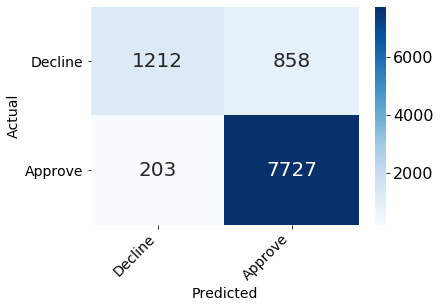

In [120]:
#accuracy score
print(accuracy_score(y_test, y_pred))

#confusion matrix
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('Decline', 'Approve'), ('Decline', 'Approve'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

#precision, recall and f1-score
print(classification_report(y_test, y_pred))

Recall Test: 0.97 Train: 0.98
Precision Test: 0.9 Train: 0.9
Roc Test: 0.93 Train: 0.93


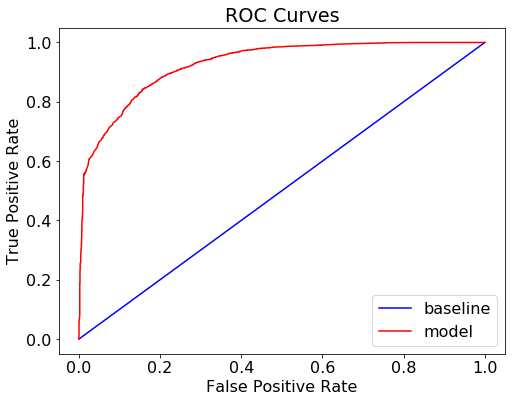

In [121]:
# Evaluating model performance unsing AUC
train_probs = adb_clf.predict_proba(X_train)[:, 1]
probs = adb_clf.predict_proba(X_test)[:, 1]
train_predictions = adb_clf.predict(X_train)
predictions = adb_clf.predict(X_test)
ada_AUC=roc_auc_score(y_test, probs)

evaluate_model(predictions, probs, train_predictions, train_probs)

# Stochastic Gradient Boosting (for Annualized Returns)

In [123]:
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns'])

X = data.loc[:, xVar]
y = data.annualized_returns

#used to get dummy variables
X = pd.get_dummies(X)

In [125]:
#train/test split cell
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

#remove random state eventually

In [173]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

sgbt = GradientBoostingRegressor(
    max_depth=1
    , subsample=0.33
    , max_features=0.67
    , n_estimators=100
#     , random_state=42
)
sgbt.fit(X_train, y_train)

# Predict the test set labels
y_pred = sgbt.predict(X_test)

# Evaluate test set RMSE 'rmse_test'
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print 'rmse_test'
print('Test set RMSE: {:.2f}'.format(rmse_test))

Test set RMSE: 1512.64


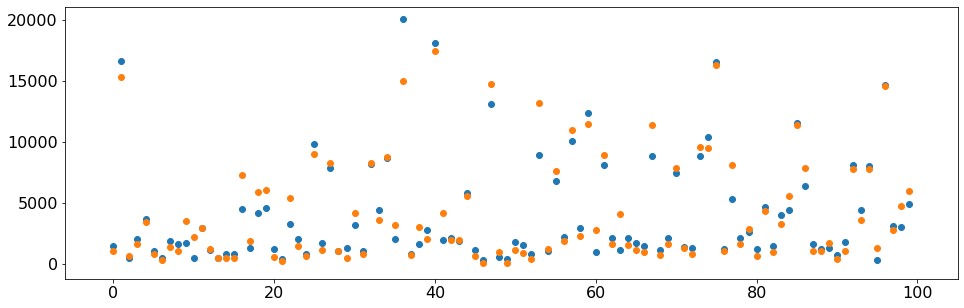

In [174]:
limit = 100 #max = 10000

x = np.arange(len(y_test))[:limit]
# y_test.values.tolist()

plt.scatter(x, y_test[:limit])
plt.scatter(x, y_pred[:limit])

fig = plt.gcf()
fig.set_size_inches(16,5)

plt.show()

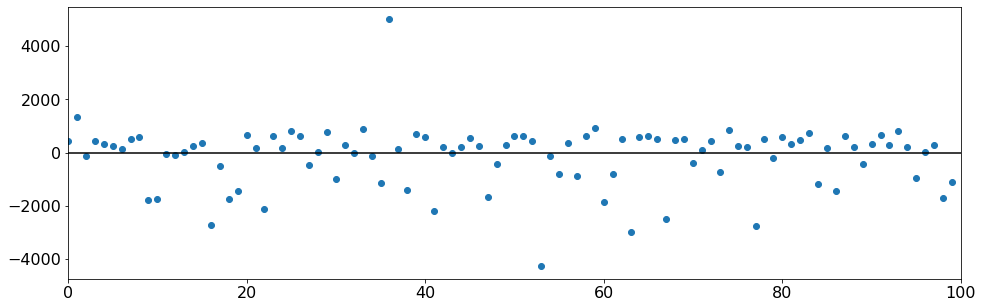

In [175]:
#showing the difference plotted instead of each variable
limit = 100 #max = 10000

x = np.arange(len(y_test))[:limit]
y_plot = y_test-y_pred
# print(np.mean(y_plot))

plt.scatter(x, y_plot[:limit])
plt.hlines(0, xmin=0, xmax=limit)

plt.xlim(0,limit)

fig = plt.gcf()
fig.set_size_inches(16,5)

plt.show()